In [ ]:
!pip install tti
!pip install ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=4e5d5a9e4fb0657e47f6adb19482ef165d2ffa57babdad08dcf8c97314b42b3b
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol for Rivian Automotive
ticker = "RIVN"

# Define the start and end dates
start_date = "2024-01-01"
end_date = "2024-10-11"

# Download stock data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Filter out only the 'Close' price
RIVN = stock_data

RIVN.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
RIVN.reset_index(inplace=True)
RIVN.set_index('Date', inplace=True)


[*********************100%***********************]  1 of 1 completed


In [ ]:
df = RIVN
df.head()

,open,high,low,close,adj_close,volume
Date,,,,,,
2024-01-02 00:00:00+00:00,21.10,21.10,21.940001,20.760000,21.855000,49626300
2024-01-03 00:00:00+00:00,20.32,20.32,20.660000,19.660000,20.530001,35634500
2024-01-04 00:00:00+00:00,19.50,19.50,20.295000,19.475000,19.920000,28453000
2024-01-05 00:00:00+00:00,19.08,19.08,19.900000,19.000000,19.379999,27403000
2024-01-08 00:00:00+00:00,19.58,19.58,19.580000,18.889999,19.059999,18745500


### Oscillators

#### RSI (14)

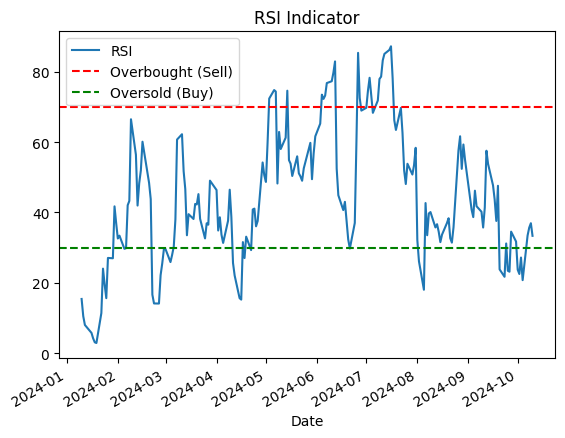

In [ ]:
import pandas as pd
from ta.momentum import RSIIndicator  # Using the 'ta' library for RSI
import matplotlib.pyplot as plt

# Calculate RSI
rsi_indicator = RSIIndicator(df['close'], window=7)  # Using a 14-day window for RSI, a common choice
df['RSI'] = rsi_indicator.rsi()

# Define RSI thresholds for buy/sell signals
rsi_buy_threshold = 30  # Buy when RSI is below 30 (oversold condition)
rsi_sell_threshold = 70  # Sell when RSI is above 70 (overbought condition)

# Generate buy/sell signals based on RSI
df['RSI_signal'] = df['RSI'].apply(lambda x: 'Buy' if x < rsi_buy_threshold else 'Sell' if x > rsi_sell_threshold else 'Hold')

# Show the Graph for RSI
df[['RSI']].plot(title="RSI Indicator")
plt.axhline(y=70, color='r', linestyle='--', label='Overbought (Sell)')
plt.axhline(y=30, color='g', linestyle='--', label='Oversold (Buy)')
plt.legend()
plt.show()

In [ ]:
df[['RSI', 'RSI_signal']][-8:]

,RSI,RSI_signal
Date,,
2024-10-01 00:00:00+00:00,30.041344,Hold
2024-10-02 00:00:00+00:00,29.260553,Buy
2024-10-03 00:00:00+00:00,31.330442,Hold
2024-10-04 00:00:00+00:00,27.520833,Buy
2024-10-07 00:00:00+00:00,33.535384,Hold
2024-10-08 00:00:00+00:00,34.634949,Hold
2024-10-09 00:00:00+00:00,35.212086,Hold
2024-10-10 00:00:00+00:00,33.690426,Hold


#### MACD (12, 26)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, MACD

# Assuming df is already defined and contains a 'close' column with stock prices
# Calculate MACD using the specified fast and slow periods
macd_indicator = MACD(df['close'], window_slow=26, window_fast=12, window_sign=9)  # Default signal window is 9

# Add MACD values and signal line to the DataFrame
df['MACD'] = macd_indicator.macd()
df['MACD_signal'] = macd_indicator.macd_signal()
df['MACD_diff'] = df['MACD'] - df['MACD_signal']  # Positive if MACD is above the signal line

def get_macd_signal(row):
    if row['MACD_diff'] > 0:
        return 'Buy'
    elif row['MACD_diff'] < 0:
        return 'Sell'
    else:
        return 'Hold'

# Apply the function to determine buy/sell/hold signals based on MACD difference
df['MACD_trade_signal'] = df.apply(get_macd_signal, axis=1)

# Display the last 8 rows of MACD and signals
df[['MACD', 'MACD_signal', 'MACD_trade_signal']][-8:]

,MACD,MACD_signal,MACD_trade_signal
Date,,,
2024-10-01 00:00:00+00:00,-0.710746,-0.534305,Sell
2024-10-02 00:00:00+00:00,-0.764099,-0.580264,Sell
2024-10-03 00:00:00+00:00,-0.786024,-0.621416,Sell
2024-10-04 00:00:00+00:00,-0.843304,-0.665793,Sell
2024-10-07 00:00:00+00:00,-0.844668,-0.701568,Sell
2024-10-08 00:00:00+00:00,-0.829729,-0.727200,Sell
2024-10-09 00:00:00+00:00,-0.805378,-0.742836,Sell
2024-10-10 00:00:00+00:00,-0.792278,-0.752724,Sell


#### Bollinger Bands

Buy if the price is near or below the lower band, Sell if near or above the upper band, Hold otherwise.

In [ ]:
from ta.volatility import BollingerBands

# Calculate Bollinger Bands with a 20-day window, standard deviation of 2
bb_indicator = BollingerBands(close=df['close'], window=10, window_dev=2)
df['BB_upper'] = bb_indicator.bollinger_hband()
df['BB_lower'] = bb_indicator.bollinger_lband()
df['BB_middle'] = bb_indicator.bollinger_mavg()

In [ ]:
def get_bb_signal(row):
    if row['close'] <= row['BB_lower']:
        return 'Buy'
    elif row['close'] >= row['BB_upper']:
        return 'Sell'
    else:
        return 'Hold'

df['BB_signal'] = df.apply(get_bb_signal, axis=1)

In [ ]:
df_filtered = df.loc['2024-10-01':'2024-10-11']

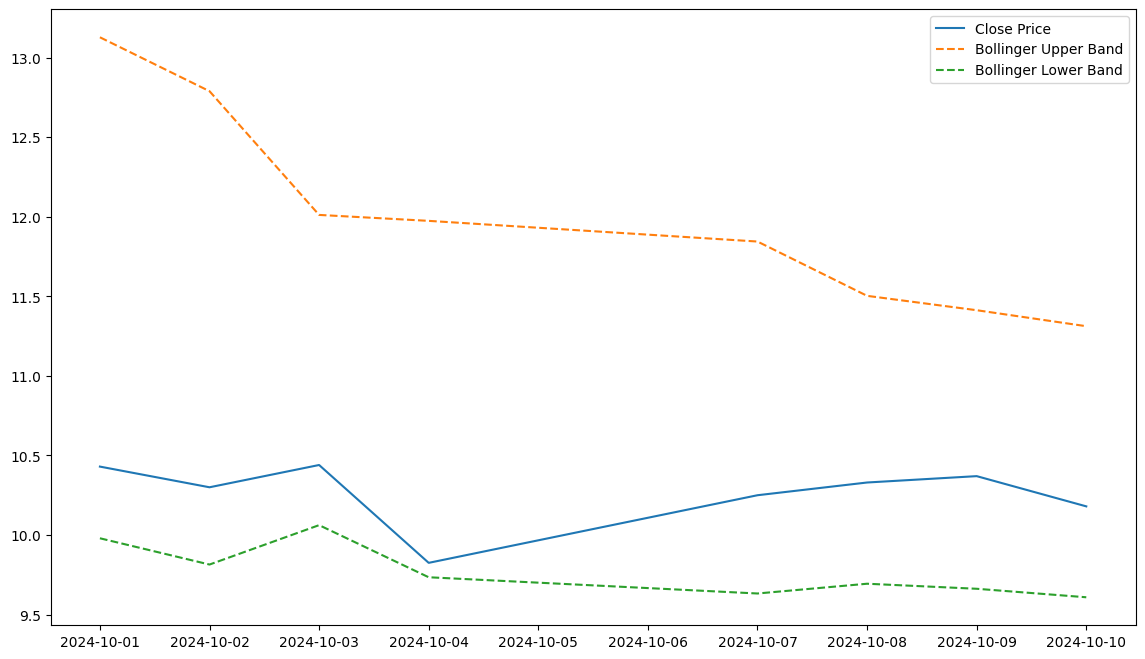

In [ ]:
import matplotlib.pyplot as plt

# Plot with buy/sell markers
plt.figure(figsize=(14, 8))
plt.plot(df_filtered.index, df_filtered['close'], label='Close Price')
plt.plot(df_filtered.index, df_filtered['BB_upper'], linestyle='--', label='Bollinger Upper Band')
plt.plot(df_filtered.index, df_filtered['BB_lower'], linestyle='--', label='Bollinger Lower Band')
# Add markers for buy/sell based on Overall_Signal
plt.legend()
plt.show()


In [ ]:
display_columns = ['close', 'BB_upper', 'BB_lower', 'BB_signal']
dashboard = df_filtered[display_columns]
dashboard

,close,BB_upper,BB_lower,BB_signal
Date,,,,
2024-10-01 00:00:00+00:00,10.430,13.128527,9.979473,Hold
2024-10-02 00:00:00+00:00,10.300,12.789623,9.814376,Hold
2024-10-03 00:00:00+00:00,10.440,12.011968,10.062031,Hold
2024-10-04 00:00:00+00:00,9.825,11.974593,9.734407,Hold
2024-10-07 00:00:00+00:00,10.250,11.844629,9.632371,Hold
2024-10-08 00:00:00+00:00,10.330,11.503288,9.693712,Hold
2024-10-09 00:00:00+00:00,10.370,11.412957,9.662043,Hold
2024-10-10 00:00:00+00:00,10.180,11.312421,9.608579,Hold


#### Momentum (10)

In [ ]:
# Calculate Momentum Indicator manually
n = 10  # Period for momentum
df['Momentum'] = df['close'] - df['close'].shift(n)

# Function to determine buy/sell/hold signals based on Momentum
def get_momentum_signal(row):
    if row['Momentum'] > 0:
        return 'Buy'
    elif row['Momentum'] < 0:
        return 'Sell'
    else:
        return 'Hold'

df['Momentum_signal'] = df.apply(get_momentum_signal, axis=1)
df[['Momentum', 'Momentum_signal']][-8:]

,Momentum,Momentum_signal
Date,,
2024-10-01 00:00:00+00:00,-2.620000,Sell
2024-10-02 00:00:00+00:00,-2.520000,Sell
2024-10-03 00:00:00+00:00,-2.650001,Sell
2024-10-04 00:00:00+00:00,-1.825000,Sell
2024-10-07 00:00:00+00:00,-1.160000,Sell
2024-10-08 00:00:00+00:00,-1.400000,Sell
2024-10-09 00:00:00+00:00,-0.610000,Sell
2024-10-10 00:00:00+00:00,-0.770000,Sell


#### Summary for Oscillators

In [ ]:
df[['close', 'RSI', 'RSI_signal', 'MACD', 'MACD_signal', 'MACD_trade_signal', 'BB_upper', 'BB_lower', 'BB_signal', 'Momentum', 'Momentum_signal']][-8:]

,close,RSI,RSI_signal,MACD,MACD_signal,MACD_trade_signal,BB_upper,BB_lower,BB_signal,Momentum,Momentum_signal
Date,,,,,,,,,,,
2024-10-01 00:00:00+00:00,10.430,30.041344,Hold,-0.710746,-0.534305,Sell,13.128527,9.979473,Hold,-2.620000,Sell
2024-10-02 00:00:00+00:00,10.300,29.260553,Buy,-0.764099,-0.580264,Sell,12.789623,9.814376,Hold,-2.520000,Sell
2024-10-03 00:00:00+00:00,10.440,31.330442,Hold,-0.786024,-0.621416,Sell,12.011968,10.062031,Hold,-2.650001,Sell
2024-10-04 00:00:00+00:00,9.825,27.520833,Buy,-0.843304,-0.665793,Sell,11.974593,9.734407,Hold,-1.825000,Sell
2024-10-07 00:00:00+00:00,10.250,33.535384,Hold,-0.844668,-0.701568,Sell,11.844629,9.632371,Hold,-1.160000,Sell
2024-10-08 00:00:00+00:00,10.330,34.634949,Hold,-0.829729,-0.727200,Sell,11.503288,9.693712,Hold,-1.400000,Sell
2024-10-09 00:00:00+00:00,10.370,35.212086,Hold,-0.805378,-0.742836,Sell,11.412957,9.662043,Hold,-0.610000,Sell
2024-10-10 00:00:00+00:00,10.180,33.690426,Hold,-0.792278,-0.752724,Sell,11.312421,9.608579,Hold,-0.770000,Sell


In [ ]:
# Create a new DataFrame to hold the counts of buy/sell/hold signals
summary_df = pd.DataFrame(index=df.index)

# Count the total number of Buy, Sell, Hold signals across all indicators
summary_df['Total_Buy'] = (
    (df['RSI_signal'] == 'Buy').astype(int) +
    (df['MACD_trade_signal'] == 'Buy').astype(int) +
    (df['Momentum_signal'] == 'Buy').astype(int)
)

summary_df['Total_Sell'] = (
    (df['RSI_signal'] == 'Sell').astype(int) +
    (df['MACD_trade_signal'] == 'Sell').astype(int) +
    (df['Momentum_signal'] == 'Sell').astype(int)
)

summary_df['Total_Hold'] = (
    (df['RSI_signal'] == 'Hold').astype(int) +
    (df['MACD_trade_signal'] == 'Hold').astype(int) +
    (df['Momentum_signal'] == 'Hold').astype(int)
)

# Optionally reset the index if you want a clean DataFrame
summary_df.reset_index(inplace=True)

# Display the summary DataFrame for the last 8 days
summary_osc = summary_df[-8:]
summary_osc.set_index('Date', inplace=True)
summary_osc

,Total_Buy,Total_Sell,Total_Hold
Date,,,
2024-10-01 00:00:00+00:00,0,2,1
2024-10-02 00:00:00+00:00,1,2,0
2024-10-03 00:00:00+00:00,0,2,1
2024-10-04 00:00:00+00:00,1,2,0
2024-10-07 00:00:00+00:00,0,2,1
2024-10-08 00:00:00+00:00,0,2,1
2024-10-09 00:00:00+00:00,0,2,1
2024-10-10 00:00:00+00:00,0,2,1


### Moving Averages

#### EMA(10) and SMA(10)

In [ ]:
from ta.trend import EMAIndicator, SMAIndicator

# Calculate 10-day EMA
ema_indicator = EMAIndicator(close=df['close'], window=10)
df['EMA_10'] = ema_indicator.ema_indicator()

# Calculate 10-day SMA
sma_indicator = SMAIndicator(close=df['close'], window=10)
df['SMA_10'] = sma_indicator.sma_indicator()

In [ ]:
# Generate EMA 10 signals
def get_ema_signal(row):
    if row['close'] > row['EMA_10']:
        return 'Buy'
    elif row['close'] < row['EMA_10']:
        return 'Sell'
    else:
        return 'Hold'

df['EMA_10_signal'] = df.apply(get_ema_signal, axis=1)

# Generate SMA 10 signals
def get_sma_signal(row):
    if row['close'] > row['SMA_10']:
        return 'Buy'
    elif row['close'] < row['SMA_10']:
        return 'Sell'
    else:
        return 'Hold'

df['SMA_10_signal'] = df.apply(get_sma_signal, axis=1)
df[['EMA_10', 'EMA_10_signal', 'SMA_10', 'SMA_10_signal']][-3:]

,EMA_10,EMA_10_signal,SMA_10,SMA_10_signal
Date,,,,
2024-10-08 00:00:00+00:00,10.686204,Sell,10.5985,Sell
2024-10-09 00:00:00+00:00,10.628712,Sell,10.5375,Sell
2024-10-10 00:00:00+00:00,10.547128,Sell,10.4605,Sell


#### EMA and SMA w/ windows [10, 20, 30, 50, 100]

In [ ]:
from ta.trend import EMAIndicator, SMAIndicator

# Define the list of windows for which we want to calculate EMA and SMA
windows = [10, 20, 30, 50, 100]

# Loop through each window to calculate EMA and SMA and their signals
for window in windows:
    # Calculate EMA
    ema_indicator = EMAIndicator(close=df['close'], window=window)
    df[f'EMA_{window}'] = ema_indicator.ema_indicator()

    # Generate EMA signals
    def get_ema_signal(row, window=window):
        if row['close'] > row[f'EMA_{window}']:
            return 'Buy'
        elif row['close'] < row[f'EMA_{window}']:
            return 'Sell'
        else:
            return 'Hold'

    df[f'EMA_{window}_signal'] = df.apply(get_ema_signal, axis=1)

    # Calculate SMA
    sma_indicator = SMAIndicator(close=df['close'], window=window)
    df[f'SMA_{window}'] = sma_indicator.sma_indicator()

    # Generate SMA signals
    def get_sma_signal(row, window=window):
        if row['close'] > row[f'SMA_{window}']:
            return 'Buy'
        elif row['close'] < row[f'SMA_{window}']:
            return 'Sell'
        else:
            return 'Hold'

    df[f'SMA_{window}_signal'] = df.apply(get_sma_signal, axis=1)

# Display the DataFrame with the new columns for the last 8 rows
columns_to_display = ['close']
for window in windows:
    columns_to_display.extend([f'EMA_{window}', f'EMA_{window}_signal', f'SMA_{window}', f'SMA_{window}_signal'])

df[columns_to_display].tail(8)


,close,EMA_10,EMA_10_signal,SMA_10,SMA_10_signal,EMA_20,EMA_20_signal,SMA_20,SMA_20_signal,EMA_30,...,SMA_30,SMA_30_signal,EMA_50,EMA_50_signal,SMA_50,SMA_50_signal,EMA_100,EMA_100_signal,SMA_100,SMA_100_signal
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:00+00:00,10.430,11.478405,Sell,11.5540,Sell,12.090476,Sell,12.34150,Sell,12.470205,...,12.686833,Sell,12.810153,Sell,13.4050,Sell,12.989805,Sell,12.83267,Sell
2024-10-02 00:00:00+00:00,10.300,11.264149,Sell,11.3020,Sell,11.919954,Sell,12.20600,Sell,12.330191,...,12.590500,Sell,12.711716,Sell,13.2800,Sell,12.936542,Sell,12.83527,Sell
2024-10-03 00:00:00+00:00,10.440,11.114304,Sell,11.0370,Sell,11.779006,Sell,12.06400,Sell,12.208244,...,12.510167,Sell,12.622629,Sell,13.1678,Sell,12.887106,Sell,12.84127,Sell
2024-10-04 00:00:00+00:00,9.825,10.879885,Sell,10.8545,Sell,11.592910,Sell,11.90125,Sell,12.054486,...,12.412000,Sell,12.512918,Sell,13.0473,Sell,12.826470,Sell,12.83927,Sell
2024-10-07 00:00:00+00:00,10.250,10.765360,Sell,10.7385,Sell,11.465014,Sell,11.76325,Sell,11.938067,...,12.324000,Sell,12.424176,Sell,12.9295,Sell,12.775451,Sell,12.83067,Sell
2024-10-08 00:00:00+00:00,10.330,10.686204,Sell,10.5985,Sell,11.356918,Sell,11.63925,Sell,11.834321,...,12.211000,Sell,12.342052,Sell,12.8160,Sell,12.727026,Sell,12.83257,Sell
2024-10-09 00:00:00+00:00,10.370,10.628712,Sell,10.5375,Sell,11.262925,Sell,11.50975,Sell,11.739849,...,12.092000,Sell,12.264716,Sell,12.7010,Sell,12.680352,Sell,12.83547,Sell
2024-10-10 00:00:00+00:00,10.180,10.547128,Sell,10.4605,Sell,11.159790,Sell,11.34325,Sell,11.639213,...,11.978333,Sell,12.182963,Sell,12.5778,Sell,12.630840,Sell,12.83837,Sell


#### Summary for Moving Averages

In [ ]:
# Define the list of windows for which we have calculated EMA and SMA
windows = [10, 20, 30, 50, 100]

# Create a list of all signal columns to include in the summary
signal_columns = [f'EMA_{window}_signal' for window in windows] + [f'SMA_{window}_signal' for window in windows]

# Initialize an empty DataFrame to hold the summary
summary_df = pd.DataFrame(index=df.index)

# Count the Buy, Sell, and Hold signals for each day
summary_df['Buy_count'] = df[signal_columns].apply(lambda x: (x == 'Buy').sum(), axis=1)
summary_df['Sell_count'] = df[signal_columns].apply(lambda x: (x == 'Sell').sum(), axis=1)
summary_df['Hold_count'] = df[signal_columns].apply(lambda x: (x == 'Hold').sum(), axis=1)

# Display the daily summary for the last 8 days
summary_ma = summary_df.tail(8)
summary_ma

,Buy_count,Sell_count,Hold_count
Date,,,
2024-10-01 00:00:00+00:00,0,10,0
2024-10-02 00:00:00+00:00,0,10,0
2024-10-03 00:00:00+00:00,0,10,0
2024-10-04 00:00:00+00:00,0,10,0
2024-10-07 00:00:00+00:00,0,10,0
2024-10-08 00:00:00+00:00,0,10,0
2024-10-09 00:00:00+00:00,0,10,0
2024-10-10 00:00:00+00:00,0,10,0


### SUMMARY

In [ ]:
# Merge the two DataFrames on the Date index
combined_summary = summary_osc[['Total_Buy', 'Total_Sell', 'Total_Hold']].add(
    summary_ma[['Buy_count', 'Sell_count', 'Hold_count']].rename(columns={
        'Buy_count': 'Total_Buy',
        'Sell_count': 'Total_Sell',
        'Hold_count': 'Total_Hold'
    }),
    fill_value=0
)

# Function to determine the final decision based on the maximum count
def get_final_decision(row):
    if row['Total_Buy'] > row['Total_Sell'] and row['Total_Buy'] > row['Total_Hold']:
        return 'Buy'
    elif row['Total_Sell'] > row['Total_Buy'] and row['Total_Sell'] > row['Total_Hold']:
        return 'Sell'
    else:
        return 'Hold'

# Apply the function to each row and create a new column for the final decision
combined_summary['Final_Decision'] = combined_summary.apply(get_final_decision, axis=1)

# Reset the index if needed
combined_summary.reset_index(inplace=True)
combined_summary

,Date,Total_Buy,Total_Sell,Total_Hold,Final_Decision
0,2024-10-01 00:00:00+00:00,0,12,1,Sell
1,2024-10-02 00:00:00+00:00,1,12,0,Sell
2,2024-10-03 00:00:00+00:00,0,12,1,Sell
3,2024-10-04 00:00:00+00:00,1,12,0,Sell
4,2024-10-07 00:00:00+00:00,0,12,1,Sell
5,2024-10-08 00:00:00+00:00,0,12,1,Sell
6,2024-10-09 00:00:00+00:00,0,12,1,Sell
7,2024-10-10 00:00:00+00:00,0,12,1,Sell


### Sketch

#### ADL

/usr/local/lib/python3.10/dist-packages/tti/utils/data_preprocessing.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.10/dist-packages/tti/utils/data_preprocessing.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)



Technical Indicator data:
                                     adl
Date                                   
2024-01-02 00:00:00+00:00  8.979998e+07
2024-01-03 00:00:00+00:00  2.637801e+08
2024-01-04 00:00:00+00:00  2.940226e+08
2024-01-05 00:00:00+00:00  3.267725e+08
2024-01-08 00:00:00+00:00          -inf
...                                 ...
2024-10-04 00:00:00+00:00          -inf
2024-10-07 00:00:00+00:00          -inf
2024-10-08 00:00:00+00:00          -inf
2024-10-09 00:00:00+00:00          -inf
2024-10-10 00:00:00+00:00          -inf

[196 rows x 1 columns]

Most recent Technical Indicator value: [-inf]

Technical Indicator signal: ('sell', 1)


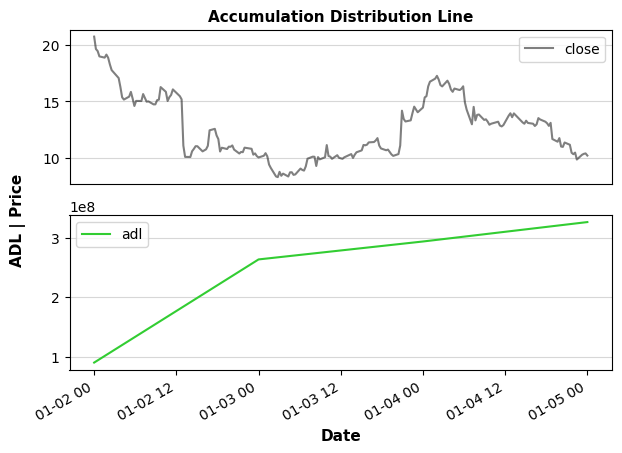

/usr/local/lib/python3.10/dist-packages/tti/utils/data_preprocessing.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.10/dist-packages/tti/utils/data_preprocessing.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)



Simulation Data:
                           signal open_trading_action stock_value    exposure  \
Date                                                                           
2024-01-02 00:00:00+00:00   hold                none       20.76         0.0   
2024-01-03 00:00:00+00:00    buy                long       19.66       19.66   
2024-01-04 00:00:00+00:00    buy                long      19.475      39.135   
2024-01-05 00:00:00+00:00    buy                long        19.0      58.135   
2024-01-08 00:00:00+00:00   sell               short   18.889999   86.469999   
...                          ...                 ...         ...         ...   
2024-10-04 00:00:00+00:00   sell               short       9.825    145.1325   
2024-10-07 00:00:00+00:00   sell               short       10.25    160.5075   
2024-10-08 00:00:00+00:00   sell               short       10.33    176.0025   
2024-10-09 00:00:00+00:00   sell               short       10.37    191.5575   
2024-10-10 00:00:00+0

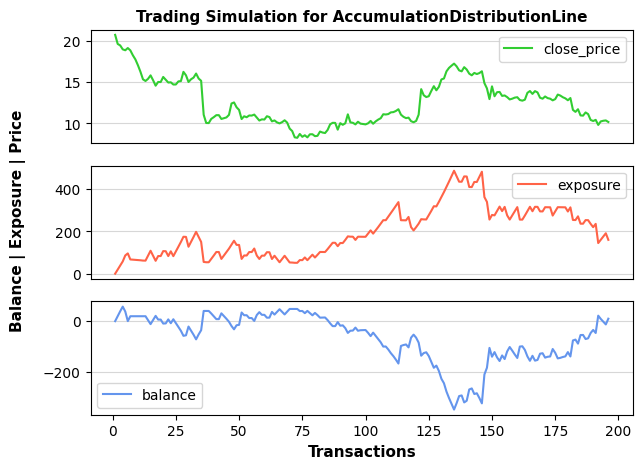

In [ ]:
"""
Trading-Technical-Indicators (tti) python library

File name: indicator_example.py
    Example code for the trading technical indicators, for the docs.

Accumulation Distribution Line indicator and SCMN.SW.csv data file is used.
"""

import pandas as pd
from tti.indicators import AccumulationDistributionLine

# Read data from csv file. Set the index to the correct column
# (dates column)

# Create indicator
adl_indicator = AccumulationDistributionLine(input_data=df)

# Get indicator's calculated data
print('\nTechnical Indicator data:\n', adl_indicator.getTiData())


# Get the most recent indicator's value
print('\nMost recent Technical Indicator value:', adl_indicator.getTiValue())

# Get signal from indicator
print('\nTechnical Indicator signal:', adl_indicator.getTiSignal())

# Show the Graph for the calculated Technical Indicator
adl_indicator.getTiGraph().show()

# Execute simulation based on trading signals
simulation_data, simulation_statistics, simulation_graph = \
    adl_indicator.getTiSimulation(
        close_values=df[['close']], max_exposure=None,
        short_exposure_factor=1.5)
print('\nSimulation Data:\n', simulation_data)
print('\nSimulation Statistics:\n', simulation_statistics)

# Show the Graph for the executed trading signal simulation
simulation_graph.show()

In [ ]:
df

,open,high,low,close,adj_close,volume,rsi,rsi_signal,macd,macd_signal,...,sma_30,sma_30_signal,ema_50,ema_50_signal,sma_50,sma_50_signal,ema_100,ema_100_signal,sma_100,sma_100_signal
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02 00:00:00+00:00,21.10,21.10,21.940001,20.760000,21.855000,49626300,NaN,Hold,NaN,NaN,...,NaN,Hold,NaN,Hold,NaN,Hold,NaN,Hold,NaN,Hold
2024-01-03 00:00:00+00:00,20.32,20.32,20.660000,19.660000,20.530001,35634500,NaN,Hold,NaN,NaN,...,NaN,Hold,NaN,Hold,NaN,Hold,NaN,Hold,NaN,Hold
2024-01-04 00:00:00+00:00,19.50,19.50,20.295000,19.475000,19.920000,28453000,NaN,Hold,NaN,NaN,...,NaN,Hold,NaN,Hold,NaN,Hold,NaN,Hold,NaN,Hold
2024-01-05 00:00:00+00:00,19.08,19.08,19.900000,19.000000,19.379999,27403000,NaN,Hold,NaN,NaN,...,NaN,Hold,NaN,Hold,NaN,Hold,NaN,Hold,NaN,Hold
2024-01-08 00:00:00+00:00,19.58,19.58,19.580000,18.889999,19.059999,18745500,NaN,Hold,NaN,NaN,...,NaN,Hold,NaN,Hold,NaN,Hold,NaN,Hold,NaN,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-04 00:00:00+00:00,10.44,10.44,10.470000,9.825000,10.050000,76581600,27.520833,Buy,-0.843304,-0.665793,...,12.412000,Sell,12.512918,Sell,13.0473,Sell,12.826470,Sell,12.83927,Sell
2024-10-07 00:00:00+00:00,10.49,10.49,10.570000,10.250000,10.380000,29217100,33.535384,Hold,-0.844668,-0.701568,...,12.324000,Sell,12.424176,Sell,12.9295,Sell,12.775451,Sell,12.83067,Sell
2024-10-08 00:00:00+00:00,10.47,10.47,10.760000,10.330000,10.420000,22441900,34.634949,Hold,-0.829729,-0.727200,...,12.211000,Sell,12.342052,Sell,12.8160,Sell,12.727026,Sell,12.83257,Sell


#### Simulation


Simulation Data:
                                close rsi_signal Action  Balance  \
Date                                                              
2024-01-03 00:00:00+00:00  19.660000       Hold   Hold  10000.0   
2024-01-04 00:00:00+00:00  19.475000       Hold   Hold  10000.0   
2024-01-05 00:00:00+00:00  19.000000       Hold   Hold  10000.0   
2024-01-08 00:00:00+00:00  18.889999       Hold   Hold  10000.0   
2024-01-09 00:00:00+00:00  19.160000       Hold   Hold  10000.0   
...                              ...        ...    ...      ...   
2024-10-04 00:00:00+00:00   9.825000        Buy   Hold      0.0   
2024-10-07 00:00:00+00:00  10.250000       Hold   Hold      0.0   
2024-10-08 00:00:00+00:00  10.330000       Hold   Hold      0.0   
2024-10-09 00:00:00+00:00  10.370000       Hold   Hold      0.0   
2024-10-10 00:00:00+00:00  10.180000       Hold   Hold      0.0   

                           Portfolio_Value  
Date                                        
2024-01-03 00:00:00

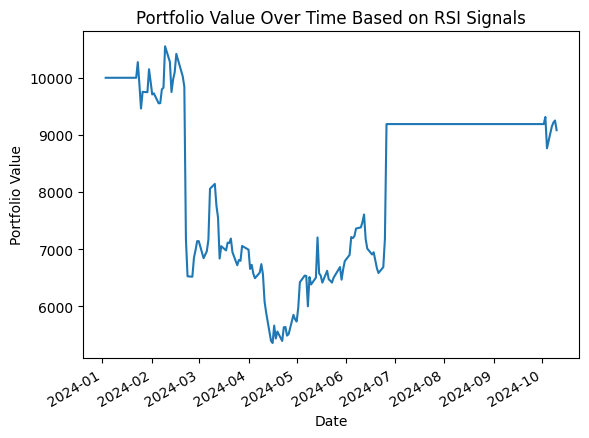

In [ ]:
# Execute simulation based on RSI trading signals
# Initialize variables for tracking portfolio performance
initial_balance = 10000  # Starting with $10,000 for example
balance = initial_balance
position = 0
simulation_data = []

for i in range(1, len(df)):
    date = df.index[i]
    signal = df['rsi_signal'].iloc[i]
    close_price = df['close'].iloc[i]

    if signal == 'Buy' and position == 0:  # Buy if RSI is oversold and no position is held
        position = balance / close_price  # Buy maximum shares possible
        balance = 0
        action = 'Buy'

    elif signal == 'Sell' and position > 0:  # Sell if RSI is overbought and position is held
        balance = position * close_price  # Sell all shares
        position = 0
        action = 'Sell'

    else:
        action = 'Hold'

    # Calculate portfolio value
    portfolio_value = balance + position * close_price
    simulation_data.append([date, close_price, signal, action, balance, portfolio_value])

# Convert simulation data to DataFrame for analysis
simulation_df = pd.DataFrame(simulation_data, columns=['Date', 'close', 'rsi_signal', 'Action', 'Balance', 'Portfolio_Value'])
simulation_df.set_index('Date', inplace=True)

# Display simulation results
print('\nSimulation Data:\n', simulation_df)

# Plot portfolio value over time
simulation_df['Portfolio_Value'].plot(title="Portfolio Value Over Time Based on RSI Signals")
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.show()



Technical Analysis Data:
                                  RSI  SMA_short  SMA_long      MACD  \
Date                                                                  
2024-01-02 00:00:00+00:00        NaN        NaN       NaN       NaN   
2024-01-03 00:00:00+00:00        NaN        NaN       NaN       NaN   
2024-01-04 00:00:00+00:00        NaN        NaN       NaN       NaN   
2024-01-05 00:00:00+00:00        NaN        NaN       NaN       NaN   
2024-01-08 00:00:00+00:00        NaN     19.557       NaN       NaN   
...                              ...        ...       ...       ...   
2024-10-04 00:00:00+00:00  20.773849     10.427   13.0473 -0.843304   
2024-10-07 00:00:00+00:00  33.448675     10.249   12.9295 -0.844668   
2024-10-08 00:00:00+00:00  35.707492     10.229   12.8160 -0.829729   
2024-10-09 00:00:00+00:00  36.955700     10.243   12.7010 -0.805378   
2024-10-10 00:00:00+00:00  33.365907     10.191   12.5778 -0.792278   

                          MACD_signal RSI_signal 

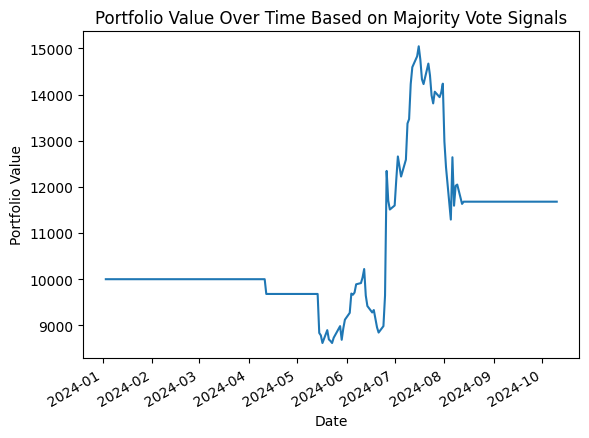

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, MACD

# Calculate Moving Averages with larger difference
short_window = 5
long_window = 50
df['SMA_short'] = SMAIndicator(df['close'], window=short_window).sma_indicator()
df['SMA_long'] = SMAIndicator(df['close'], window=long_window).sma_indicator()

# Calculate MACD and trend
macd_indicator = MACD(df['close'])
df['MACD'] = macd_indicator.macd()
df['MACD_signal'] = macd_indicator.macd_signal()
df['MACD_diff'] = df['MACD'] - df['MACD_signal']  # Positive if MACD is above the signal line

# Generate individual signals for RSI, Moving Average Crossover, and MACD
def get_rsi_signal(row):
    if row['RSI'] < rsi_buy_threshold:
        return 'Buy'
    elif row['RSI'] > rsi_sell_threshold:
        return 'Sell'
    else:
        return 'Hold'

def get_ma_signal(row):
    if row['SMA_short'] > row['SMA_long']:
        return 'Buy'
    elif row['SMA_short'] < row['SMA_long']:
        return 'Sell'
    else:
        return 'Hold'

def get_macd_signal(row):
    if row['MACD_diff'] > 0:
        return 'Buy'
    elif row['MACD_diff'] < 0:
        return 'Sell'
    else:
        return 'Hold'

# Apply individual signal functions
df['RSI_signal'] = df.apply(get_rsi_signal, axis=1)
df['MA_signal'] = df.apply(get_ma_signal, axis=1)
df['MACD_signal'] = df.apply(get_macd_signal, axis=1)

# Combine signals by majority vote
def get_majority_signal(row):
    signals = [row['RSI_signal'], row['MA_signal'], row['MACD_signal']]
    if signals.count('Buy') >= 2:
        return 'Buy'
    elif signals.count('Sell') >= 2:
        return 'Sell'
    else:
        return 'Hold'

df['Signal'] = df.apply(get_majority_signal, axis=1)

# Print signals for verification
print('\nTechnical Analysis Data:\n', df[['RSI', 'SMA_short', 'SMA_long', 'MACD', 'MACD_signal', 'RSI_signal', 'MA_signal', 'MACD_signal', 'Signal']])

# Execute simulation based on combined signals
initial_balance = 10000  # Starting with $10,000
balance = initial_balance
position = 0  # No shares held initially
simulation_data = []

for i in range(1, len(df)):
    date = df.index[i]
    signal = df['Signal'].iloc[i]
    close_price = df['close'].iloc[i]

    if signal == 'Buy' and position == 0:  # Buy if majority signals buy and no position is held
        position = balance / close_price  # Buy maximum shares possible
        balance = 0
        action = 'Buy'

    elif signal == 'Sell' and position > 0:  # Sell if majority signals sell and position is held
        balance = position * close_price  # Sell all shares
        position = 0
        action = 'Sell'

    else:
        action = 'Hold'

    # Calculate portfolio value
    portfolio_value = balance + position * close_price
    simulation_data.append([date, close_price, signal, action, balance, portfolio_value])

# Convert simulation data to DataFrame for analysis
simulation_df = pd.DataFrame(simulation_data, columns=['Date', 'Close', 'Signal', 'Action', 'Balance', 'Portfolio_Value'])
simulation_df.set_index('Date', inplace=True)

# Display simulation results
print('\nSimulation Data:\n', simulation_df)

# Plot portfolio value over time
simulation_df['Portfolio_Value'].plot(title="Portfolio Value Over Time Based on Majority Vote Signals")
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.show()


[*********************100%***********************]  1 of 1 completed


Best Parameters: {'long_ma_window': 60, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 30, 'rsi_sell_threshold': 60, 'rsi_window': 10, 'short_ma_window': 10}
Profit with Best Parameters: 6195.280349665336


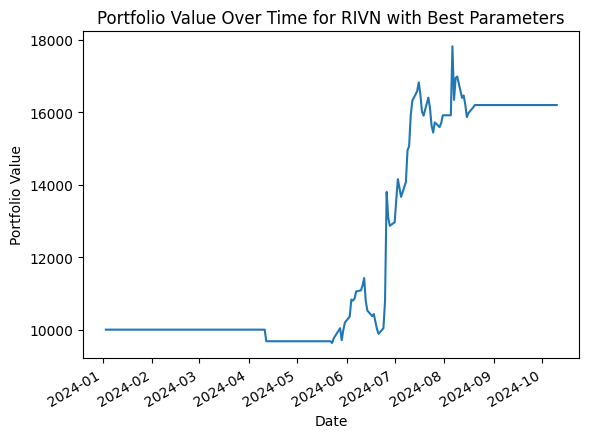

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, MACD
import yfinance as yf
from sklearn.model_selection import ParameterGrid

def stock_analysis(company_ticker, start_date='2023-01-01', end_date='2024-01-01'):
    # Fetch historical data for the given ticker
    df = yf.download(company_ticker, start=start_date, end=end_date)
    df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

    # Define a function for signal generation with configurable hyperparameters
    def generate_signals(df, rsi_window=7, rsi_buy_threshold=40, rsi_sell_threshold=60,
                         short_ma_window=10, long_ma_window=50, macd_slow=26, macd_fast=12, macd_signal=9):

        # Calculate RSI
        rsi_indicator = RSIIndicator(df['close'], window=rsi_window)
        df['RSI'] = rsi_indicator.rsi()

        # Calculate Moving Averages
        df['SMA_short'] = SMAIndicator(df['close'], window=short_ma_window).sma_indicator()
        df['SMA_long'] = SMAIndicator(df['close'], window=long_ma_window).sma_indicator()

        # Calculate MACD
        macd_indicator = MACD(df['close'], window_slow=macd_slow, window_fast=macd_fast, window_sign=macd_signal)
        df['MACD'] = macd_indicator.macd()
        df['MACD_signal'] = macd_indicator.macd_signal()
        df['MACD_diff'] = df['MACD'] - df['MACD_signal']

        # Generate individual signals for RSI, Moving Average Crossover, and MACD
        def get_rsi_signal(row):
            if row['RSI'] < rsi_buy_threshold:
                return 'Buy'
            elif row['RSI'] > rsi_sell_threshold:
                return 'Sell'
            else:
                return 'Hold'

        def get_ma_signal(row):
            if row['SMA_short'] > row['SMA_long']:
                return 'Buy'
            elif row['SMA_short'] < row['SMA_long']:
                return 'Sell'
            else:
                return 'Hold'

        def get_macd_signal(row):
            if row['MACD_diff'] > 0:
                return 'Buy'
            elif row['MACD_diff'] < 0:
                return 'Sell'
            else:
                return 'Hold'

        # Apply individual signal functions
        df['RSI_signal'] = df.apply(get_rsi_signal, axis=1)
        df['MA_signal'] = df.apply(get_ma_signal, axis=1)
        df['MACD_signal'] = df.apply(get_macd_signal, axis=1)

        # Combine signals by majority vote
        def get_majority_signal(row):
            signals = [row['RSI_signal'], row['MA_signal'], row['MACD_signal']]
            if signals.count('Buy') >= 2:
                return 'Buy'
            elif signals.count('Sell') >= 2:
                return 'Sell'
            else:
                return 'Hold'

        df['Signal'] = df.apply(get_majority_signal, axis=1)
        return df

    # Hyperparameter grid for tuning
    param_grid = {
        'rsi_window': [5, 7, 10],
        'rsi_buy_threshold': [30, 35, 40],
        'rsi_sell_threshold': [60, 65, 70],
        'short_ma_window': [5, 10, 15],
        'long_ma_window': [50, 60],
        'macd_slow': [26],
        'macd_fast': [12],
        'macd_signal': [9]
    }

    best_profit = float('-inf')
    best_params = None
    best_simulation_df = None

    # Grid search for best parameters
    for params in ParameterGrid(param_grid):
        # Generate signals with current parameters
        df_with_signals = generate_signals(df.copy(), **params)

        # Simulate trading with these signals
        initial_balance = 10000  # Starting with $10,000
        balance = initial_balance
        position = 0  # No shares held initially
        simulation_data = []

        for i in range(1, len(df_with_signals)):
            date = df_with_signals.index[i]
            signal = df_with_signals['Signal'].iloc[i]
            close_price = df_with_signals['close'].iloc[i]

            if signal == 'Buy' and position == 0:  # Buy if majority signals buy and no position is held
                position = balance / close_price  # Buy maximum shares possible
                balance = 0
                action = 'Buy'

            elif signal == 'Sell' and position > 0:  # Sell if majority signals sell and position is held
                balance = position * close_price  # Sell all shares
                position = 0
                action = 'Sell'

            else:
                action = 'Hold'

            # Calculate portfolio value
            portfolio_value = balance + position * close_price
            simulation_data.append([date, close_price, signal, action, balance, portfolio_value])

        # Convert simulation data to DataFrame for analysis
        simulation_df = pd.DataFrame(simulation_data, columns=['Date', 'Close', 'Signal', 'Action', 'Balance', 'Portfolio_Value'])
        simulation_df.set_index('Date', inplace=True)

        # Calculate profit and compare to find best parameters
        final_portfolio_value = simulation_df['Portfolio_Value'].iloc[-1]
        profit = final_portfolio_value - initial_balance

        if profit > best_profit:
            best_profit = profit
            best_params = params
            best_simulation_df = simulation_df

    # Display best parameters and corresponding profit
    print(f"Best Parameters: {best_params}")
    print(f"Profit with Best Parameters: {best_profit}")

    # Plot portfolio value over time for the best parameters
    best_simulation_df['Portfolio_Value'].plot(title=f"Portfolio Value Over Time for {company_ticker} with Best Parameters")
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.show()

    return best_params, best_profit, best_simulation_df

# Example usage
best_params, best_profit, best_simulation_df = stock_analysis('RIVN', start_date='2024-01-01', end_date='2024-10-11')


# Loop through all tickers

[*********************100%***********************]  1 of 1 completed


Analyzing RIVN...


Best Parameters for RIVN: {'long_ma_window': 50, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 30, 'rsi_sell_threshold': 60, 'rsi_window': 5, 'short_ma_window': 5}
Profit with Best Parameters for RIVN from 10/1/2024 to 10/11/2024: $0.00

Daily Summary Table for Technical Indicators:
                           Oscillator_Buy  Oscillator_Hold  Oscillator_Sell  \
Date                                                                          
2024-10-01 00:00:00+00:00               1                0                1   
2024-10-02 00:00:00+00:00               1                0                1   
2024-10-03 00:00:00+00:00               1                0                1   
2024-10-04 00:00:00+00:00               1                0                1   
2024-10-07 00:00:00+00:00               0                1                1   
2024-10-08 00:00:00+00:00               0                1                1   
2024-10-09 00:00:00+00:00               0                

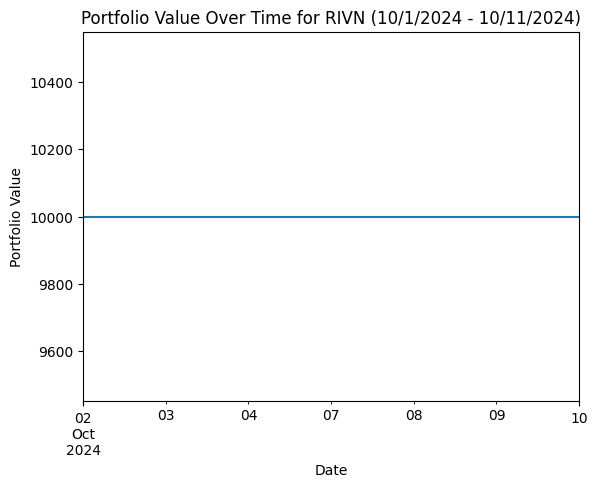

[*********************100%***********************]  1 of 1 completed


Analyzing TSLA...


Best Parameters for TSLA: {'long_ma_window': 50, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 30, 'rsi_sell_threshold': 60, 'rsi_window': 5, 'short_ma_window': 5}
Profit with Best Parameters for TSLA from 10/1/2024 to 10/11/2024: $-379.30

Daily Summary Table for Technical Indicators:
                           Oscillator_Buy  Oscillator_Hold  Oscillator_Sell  \
Date                                                                          
2024-10-01 00:00:00+00:00               1                1                0   
2024-10-02 00:00:00+00:00               1                1                0   
2024-10-03 00:00:00+00:00               0                1                1   
2024-10-04 00:00:00+00:00               0                1                1   
2024-10-07 00:00:00+00:00               0                1                1   
2024-10-08 00:00:00+00:00               0                1                1   
2024-10-09 00:00:00+00:00               0             

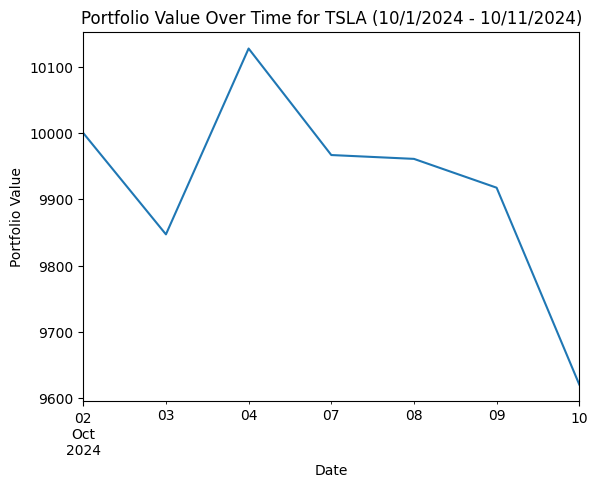

[*********************100%***********************]  1 of 1 completed


Analyzing NIO...


Best Parameters for NIO: {'long_ma_window': 50, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 30, 'rsi_sell_threshold': 60, 'rsi_window': 5, 'short_ma_window': 5}
Profit with Best Parameters for NIO from 10/1/2024 to 10/11/2024: $-1011.73

Daily Summary Table for Technical Indicators:
                           Oscillator_Buy  Oscillator_Hold  Oscillator_Sell  \
Date                                                                          
2024-10-01 00:00:00+00:00               1                0                1   
2024-10-02 00:00:00+00:00               1                0                1   
2024-10-03 00:00:00+00:00               1                0                1   
2024-10-04 00:00:00+00:00               1                1                0   
2024-10-07 00:00:00+00:00               1                0                1   
2024-10-08 00:00:00+00:00               1                1                0   
2024-10-09 00:00:00+00:00               0              

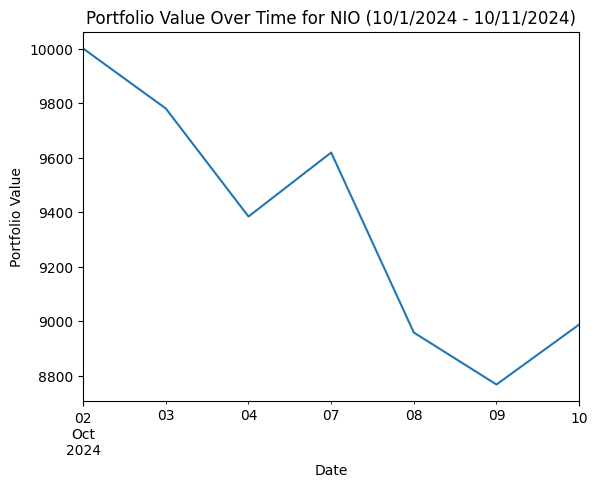

[*********************100%***********************]  1 of 1 completed


Analyzing XPEV...


Best Parameters for XPEV: {'long_ma_window': 50, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 30, 'rsi_sell_threshold': 60, 'rsi_window': 5, 'short_ma_window': 5}
Profit with Best Parameters for XPEV from 10/1/2024 to 10/11/2024: $-135.89

Daily Summary Table for Technical Indicators:
                           Oscillator_Buy  Oscillator_Hold  Oscillator_Sell  \
Date                                                                          
2024-10-01 00:00:00+00:00               1                0                1   
2024-10-02 00:00:00+00:00               1                0                1   
2024-10-03 00:00:00+00:00               1                0                1   
2024-10-04 00:00:00+00:00               1                0                1   
2024-10-07 00:00:00+00:00               1                0                1   
2024-10-08 00:00:00+00:00               1                1                0   
2024-10-09 00:00:00+00:00               1             

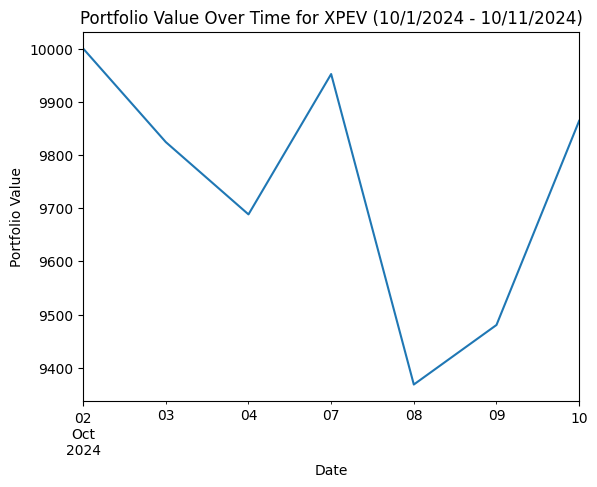

[*********************100%***********************]  1 of 1 completed


Analyzing EVGO...


Best Parameters for EVGO: {'long_ma_window': 50, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 30, 'rsi_sell_threshold': 60, 'rsi_window': 5, 'short_ma_window': 5}
Profit with Best Parameters for EVGO from 10/1/2024 to 10/11/2024: $7349.08

Daily Summary Table for Technical Indicators:
                           Oscillator_Buy  Oscillator_Hold  Oscillator_Sell  \
Date                                                                          
2024-10-01 00:00:00+00:00               1                0                1   
2024-10-02 00:00:00+00:00               1                0                1   
2024-10-03 00:00:00+00:00               1                0                1   
2024-10-04 00:00:00+00:00               1                0                1   
2024-10-07 00:00:00+00:00               1                0                1   
2024-10-08 00:00:00+00:00               1                0                1   
2024-10-09 00:00:00+00:00               1             

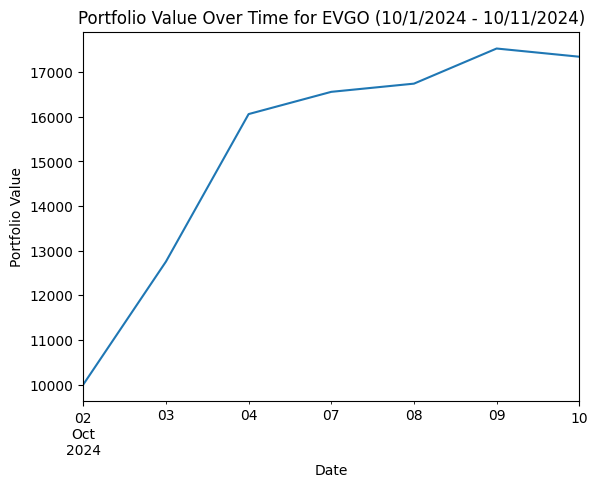

[*********************100%***********************]  1 of 1 completed


Analyzing LI...


Best Parameters for LI: {'long_ma_window': 50, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 30, 'rsi_sell_threshold': 60, 'rsi_window': 5, 'short_ma_window': 5}
Profit with Best Parameters for LI from 10/1/2024 to 10/11/2024: $-717.79

Daily Summary Table for Technical Indicators:
                           Oscillator_Buy  Oscillator_Hold  Oscillator_Sell  \
Date                                                                          
2024-10-01 00:00:00+00:00               1                0                1   
2024-10-02 00:00:00+00:00               1                0                1   
2024-10-03 00:00:00+00:00               1                0                1   
2024-10-04 00:00:00+00:00               1                0                1   
2024-10-07 00:00:00+00:00               1                0                1   
2024-10-08 00:00:00+00:00               1                1                0   
2024-10-09 00:00:00+00:00               1                1

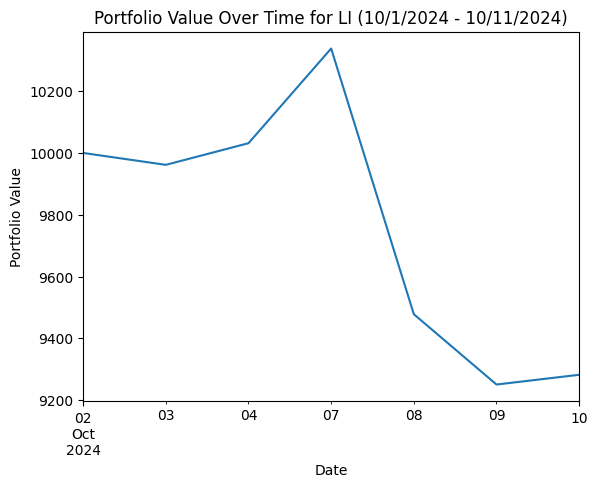

[*********************100%***********************]  1 of 1 completed


Analyzing INDI...


Best Parameters for INDI: {'long_ma_window': 50, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 30, 'rsi_sell_threshold': 60, 'rsi_window': 5, 'short_ma_window': 5}
Profit with Best Parameters for INDI from 10/1/2024 to 10/11/2024: $0.00

Daily Summary Table for Technical Indicators:
                           Oscillator_Buy  Oscillator_Hold  Oscillator_Sell  \
Date                                                                          
2024-10-01 00:00:00+00:00               1                1                0   
2024-10-02 00:00:00+00:00               1                1                0   
2024-10-03 00:00:00+00:00               1                1                0   
2024-10-04 00:00:00+00:00               1                1                0   
2024-10-07 00:00:00+00:00               1                1                0   
2024-10-08 00:00:00+00:00               1                1                0   
2024-10-09 00:00:00+00:00               1                

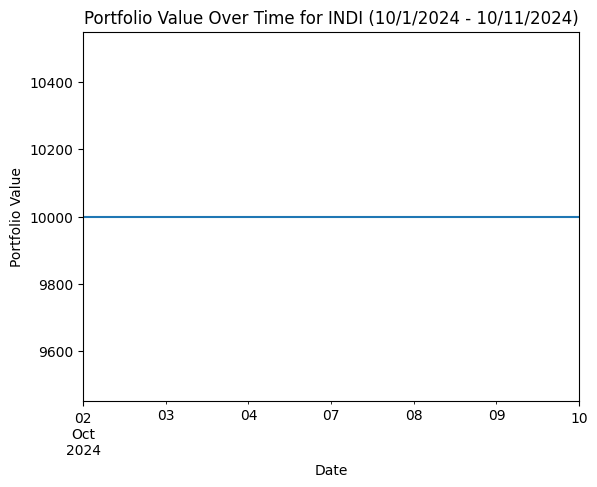

[*********************100%***********************]  1 of 1 completed


Analyzing CHPT...


Best Parameters for CHPT: {'long_ma_window': 50, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 30, 'rsi_sell_threshold': 65, 'rsi_window': 5, 'short_ma_window': 5}
Profit with Best Parameters for CHPT from 10/1/2024 to 10/11/2024: $859.38

Daily Summary Table for Technical Indicators:
                           Oscillator_Buy  Oscillator_Hold  Oscillator_Sell  \
Date                                                                          
2024-10-01 00:00:00+00:00               2                0                0   
2024-10-02 00:00:00+00:00               2                0                0   
2024-10-03 00:00:00+00:00               1                1                0   
2024-10-04 00:00:00+00:00               1                1                0   
2024-10-07 00:00:00+00:00               1                0                1   
2024-10-08 00:00:00+00:00               1                1                0   
2024-10-09 00:00:00+00:00               1              

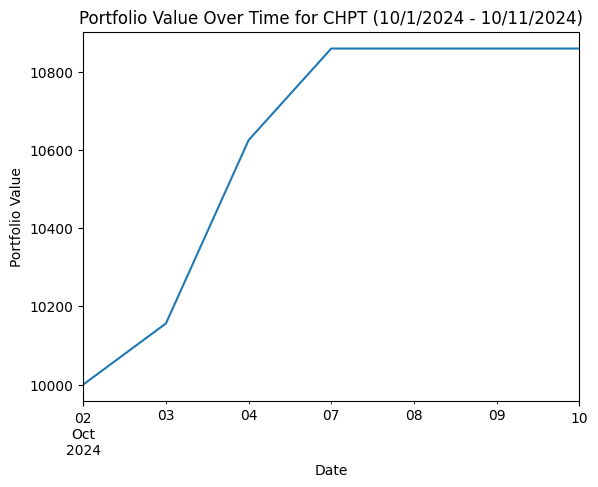

[*********************100%***********************]  1 of 1 completed


Analyzing LCID...


Best Parameters for LCID: {'long_ma_window': 50, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 30, 'rsi_sell_threshold': 60, 'rsi_window': 5, 'short_ma_window': 15}
Profit with Best Parameters for LCID from 10/1/2024 to 10/11/2024: $531.25

Daily Summary Table for Technical Indicators:
                           Oscillator_Buy  Oscillator_Hold  Oscillator_Sell  \
Date                                                                          
2024-10-01 00:00:00+00:00               1                0                1   
2024-10-02 00:00:00+00:00               1                0                1   
2024-10-03 00:00:00+00:00               0                1                1   
2024-10-04 00:00:00+00:00               0                1                1   
2024-10-07 00:00:00+00:00               0                1                1   
2024-10-08 00:00:00+00:00               0                1                1   
2024-10-09 00:00:00+00:00               0             

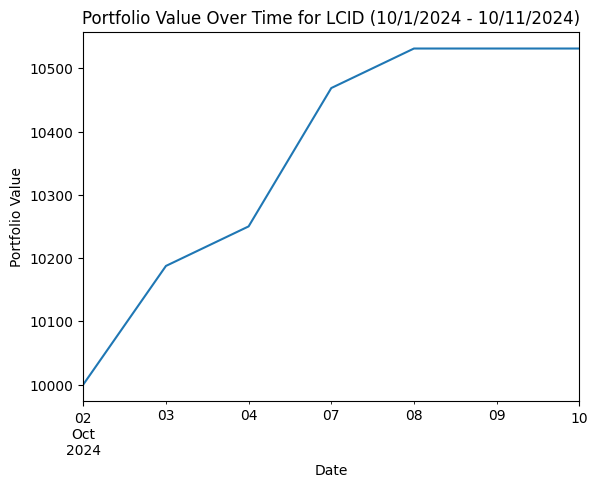

[*********************100%***********************]  1 of 1 completed


Analyzing LAZR...


Best Parameters for LAZR: {'long_ma_window': 50, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 40, 'rsi_sell_threshold': 65, 'rsi_window': 5, 'short_ma_window': 5}
Profit with Best Parameters for LAZR from 10/1/2024 to 10/11/2024: $1148.99

Daily Summary Table for Technical Indicators:
                           Oscillator_Buy  Oscillator_Hold  Oscillator_Sell  \
Date                                                                          
2024-10-01 00:00:00+00:00               1                1                0   
2024-10-02 00:00:00+00:00               1                1                0   
2024-10-03 00:00:00+00:00               2                0                0   
2024-10-04 00:00:00+00:00               1                1                0   
2024-10-07 00:00:00+00:00               1                0                1   
2024-10-08 00:00:00+00:00               1                1                0   
2024-10-09 00:00:00+00:00               1             

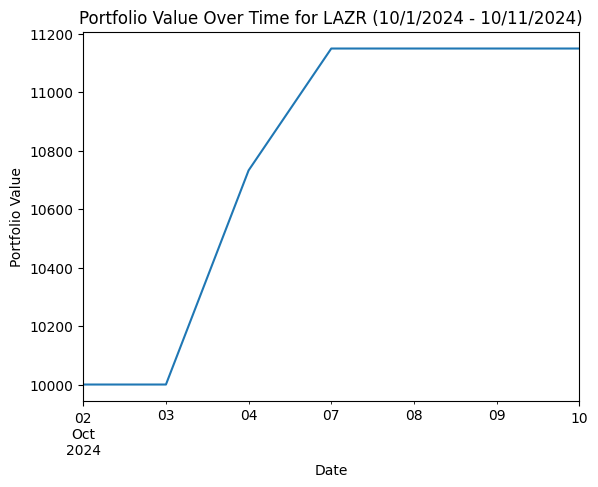


RIVN - Best Parameters: {'long_ma_window': 50, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 30, 'rsi_sell_threshold': 60, 'rsi_window': 5, 'short_ma_window': 5}
RIVN - Profit with Best Parameters from 10/1/2024 to 10/11/2024: $0.00

TSLA - Best Parameters: {'long_ma_window': 50, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 30, 'rsi_sell_threshold': 60, 'rsi_window': 5, 'short_ma_window': 5}
TSLA - Profit with Best Parameters from 10/1/2024 to 10/11/2024: $-379.30

NIO - Best Parameters: {'long_ma_window': 50, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 30, 'rsi_sell_threshold': 60, 'rsi_window': 5, 'short_ma_window': 5}
NIO - Profit with Best Parameters from 10/1/2024 to 10/11/2024: $-1011.73

XPEV - Best Parameters: {'long_ma_window': 50, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 30, 'rsi_sell_threshold': 60, 'rsi_window': 5, 'short_ma_window': 5}
XPEV - Profit with Bes

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, MACD
import yfinance as yf
from sklearn.model_selection import ParameterGrid

def stock_analysis(company_ticker, start_date='2023-01-01', end_date='2024-10-11'):
    # Fetch historical data for the given ticker
    df = yf.download(company_ticker, start=start_date, end=end_date)
    df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

    # Define a function for signal generation with configurable hyperparameters
    def generate_signals(df, rsi_window=7, rsi_buy_threshold=40, rsi_sell_threshold=60,
                         short_ma_window=10, long_ma_window=50, macd_slow=26, macd_fast=12, macd_signal=9):

        # Calculate RSI
        rsi_indicator = RSIIndicator(df['close'], window=rsi_window)
        df['RSI'] = rsi_indicator.rsi()

        # Calculate Moving Averages
        df['SMA_short'] = SMAIndicator(df['close'], window=short_ma_window).sma_indicator()
        df['SMA_long'] = SMAIndicator(df['close'], window=long_ma_window).sma_indicator()

        # Calculate MACD
        macd_indicator = MACD(df['close'], window_slow=macd_slow, window_fast=macd_fast, window_sign=macd_signal)
        df['MACD'] = macd_indicator.macd()
        df['MACD_signal'] = macd_indicator.macd_signal()
        df['MACD_diff'] = df['MACD'] - df['MACD_signal']

        # Generate individual signals for RSI, Moving Average Crossover, and MACD
        def get_rsi_signal(row):
            if row['RSI'] < rsi_buy_threshold:
                return 'Buy'
            elif row['RSI'] > rsi_sell_threshold:
                return 'Sell'
            else:
                return 'Hold'

        def get_ma_signal(row):
            if row['SMA_short'] > row['SMA_long']:
                return 'Buy'
            elif row['SMA_short'] < row['SMA_long']:
                return 'Sell'
            else:
                return 'Hold'

        def get_macd_signal(row):
            if row['MACD_diff'] > 0:
                return 'Buy'
            elif row['MACD_diff'] < 0:
                return 'Sell'
            else:
                return 'Hold'

        # Apply individual signal functions
        df['RSI_signal'] = df.apply(get_rsi_signal, axis=1)
        df['MA_signal'] = df.apply(get_ma_signal, axis=1)
        df['MACD_signal'] = df.apply(get_macd_signal, axis=1)

        # Combine signals by majority vote
        def get_majority_signal(row):
            signals = [row['RSI_signal'], row['MA_signal'], row['MACD_signal']]
            if signals.count('Buy') >= 2:
                return 'Buy'
            elif signals.count('Sell') >= 2:
                return 'Sell'
            else:
                return 'Hold'

        df['Signal'] = df.apply(get_majority_signal, axis=1)
        return df

    # Hyperparameter grid for tuning
    param_grid = {
        'rsi_window': [5, 7, 10],
        'rsi_buy_threshold': [30, 35, 40],
        'rsi_sell_threshold': [60, 65, 70],
        'short_ma_window': [5, 10, 15],
        'long_ma_window': [50, 60],
        'macd_slow': [26],
        'macd_fast': [12],
        'macd_signal': [9]
    }

    best_profit = float('-inf')
    best_params = None
    best_simulation_df = None
    best_analysis_df = None

    # Grid search for best parameters
    for params in ParameterGrid(param_grid):
        # Generate signals with current parameters
        df_with_signals = generate_signals(df.copy(), **params)

        # Filter data for the specified date range (10/1/2024 to 10/11/2024)
        analysis_df = df_with_signals.loc['2024-10-01':'2024-10-11']

        # Simulate trading within this date range
        initial_balance = 10000  # Starting with $10,000
        balance = initial_balance
        position = 0  # No shares held initially
        simulation_data = []

        for i in range(1, len(analysis_df)):
            date = analysis_df.index[i]
            signal = analysis_df['Signal'].iloc[i]
            close_price = analysis_df['close'].iloc[i]

            if signal == 'Buy' and position == 0:  # Buy if majority signals buy and no position is held
                position = balance / close_price  # Buy maximum shares possible
                balance = 0
                action = 'Buy'

            elif signal == 'Sell' and position > 0:  # Sell if majority signals sell and position is held
                balance = position * close_price  # Sell all shares
                position = 0
                action = 'Sell'

            else:
                action = 'Hold'

            # Calculate portfolio value
            portfolio_value = balance + position * close_price
            simulation_data.append([date, close_price, signal, action, balance, portfolio_value])

        # Convert simulation data to DataFrame for analysis
        simulation_df = pd.DataFrame(simulation_data, columns=['Date', 'Close', 'Signal', 'Action', 'Balance', 'Portfolio_Value'])
        simulation_df.set_index('Date', inplace=True)

        # Calculate profit for this parameter set
        final_portfolio_value = simulation_df['Portfolio_Value'].iloc[-1]
        profit = final_portfolio_value - initial_balance

        # Update best parameters if current profit is greater
        if profit > best_profit:
            best_profit = profit
            best_params = params
            best_simulation_df = simulation_df
            best_analysis_df = analysis_df  # Store the analysis DataFrame for the best parameters

    # Display best parameters and corresponding profit
    print(f"Best Parameters for {company_ticker}: {best_params}")
    print(f"Profit with Best Parameters for {company_ticker} from 10/1/2024 to 10/11/2024: ${best_profit:.2f}")

    # Generate daily summary table for the best parameter set
    daily_summary = best_analysis_df.groupby(best_analysis_df.index).apply(
        lambda x: pd.Series({
            'Oscillator_Buy': (x[['RSI_signal', 'MACD_signal']] == 'Buy').sum().sum(),
            'Oscillator_Hold': (x[['RSI_signal', 'MACD_signal']] == 'Hold').sum().sum(),
            'Oscillator_Sell': (x[['RSI_signal', 'MACD_signal']] == 'Sell').sum().sum(),
            'MA_Buy': (x['MA_signal'] == 'Buy').sum(),
            'MA_Hold': (x['MA_signal'] == 'Hold').sum(),
            'MA_Sell': (x['MA_signal'] == 'Sell').sum(),
            'Summary_Buy': (x[['RSI_signal', 'MACD_signal', 'MA_signal']] == 'Buy').sum().sum(),
            'Summary_Hold': (x[['RSI_signal', 'MACD_signal', 'MA_signal']] == 'Hold').sum().sum(),
            'Summary_Sell': (x[['RSI_signal', 'MACD_signal', 'MA_signal']] == 'Sell').sum().sum()
        })
    )

    print("\nDaily Summary Table for Technical Indicators:")
    print(daily_summary)

    # Display the technical analysis dashboard for the best parameter set
    print(f"\nTechnical Analysis Dashboard for {company_ticker} (10/1/2024 - 10/11/2024):")
    print(best_analysis_df[['close', 'RSI', 'RSI_signal', 'MACD', 'MACD_signal', 'MACD_diff', 'MA_signal', 'Signal']])

    # Plot portfolio value over time for the best parameter set
    best_simulation_df['Portfolio_Value'].plot(title=f"Portfolio Value Over Time for {company_ticker} (10/1/2024 - 10/11/2024)")
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.show()

    return best_params, best_profit, best_simulation_df

# Define the tickers to analyze
tickers = [
    "RIVN",  # Rivian Automotive
    "TSLA",  # Tesla
    "NIO",   # Nio Inc ADR
    "XPEV",  # Xpeng A ADR
    "EVGO",  # Evgo Inc
    "LI",    # Li Auto ADR
    "INDI",  # Indie Semiconductor Inc Class A
    "CHPT",  # ChargePoint Holdings Inc Class A
    "LCID",  # Lucid Group Inc
    "LAZR"   # Luminar Technologies A
]

# Loop over each ticker and perform stock analysis
results = {}
for ticker in tickers:
    print(f"\nAnalyzing {ticker}...")
    best_params, best_profit, best_simulation_df = stock_analysis(ticker, start_date='2024-01-01', end_date='2024-10-11')

    # Store results in the dictionary
    results[ticker] = {
        "best_params": best_params,
        "best_profit": best_profit,
        "simulation_df": best_simulation_df
    }

# Display summary of results for each ticker
for ticker, result in results.items():
    print(f"\n{ticker} - Best Parameters: {result['best_params']}")
    print(f"{ticker} - Profit with Best Parameters from 10/1/2024 to 10/11/2024: ${result['best_profit']:.2f}")


[*********************100%***********************]  1 of 1 completed


Best Parameters: {'long_ma_window': 60, 'macd_fast': 12, 'macd_signal': 9, 'macd_slow': 26, 'rsi_buy_threshold': 30, 'rsi_sell_threshold': 60, 'rsi_window': 10, 'short_ma_window': 10}
Profit with Best Parameters: 6195.280349665336


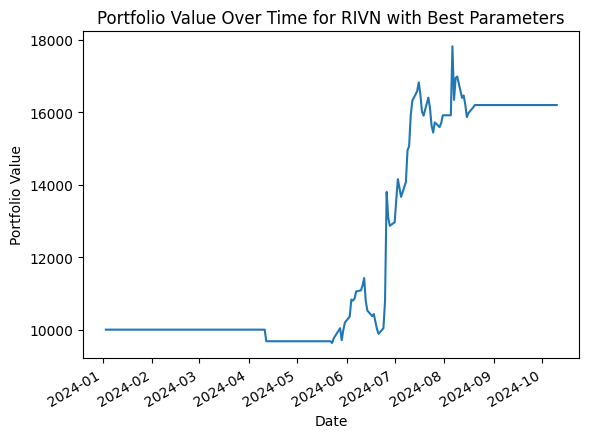

                                 RSI  SMA_short   SMA_long      MACD  \
Date                                                                   
2024-10-01 00:00:00+00:00  26.684524  12.109333  13.916500 -0.710746   
2024-10-02 00:00:00+00:00  25.717418  11.932000  13.832333 -0.764099   
2024-10-03 00:00:00+00:00  28.804901  11.727333  13.748667 -0.786024   
2024-10-04 00:00:00+00:00  23.946755  11.489667  13.640250 -0.843304   
2024-10-07 00:00:00+00:00  32.666558  11.293667  13.531917 -0.844668   
2024-10-08 00:00:00+00:00  34.243393  11.112333  13.420417 -0.829729   
2024-10-09 00:00:00+00:00  35.087910  10.949000  13.305417 -0.805378   
2024-10-10 00:00:00+00:00  32.860531  10.755000  13.192750 -0.792278   

                          MACD_signal Signal  
Date                                          
2024-10-01 00:00:00+00:00        Sell   Sell  
2024-10-02 00:00:00+00:00        Sell   Sell  
2024-10-03 00:00:00+00:00        Sell   Sell  
2024-10-04 00:00:00+00:00        Sell   Sell

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, MACD
import yfinance as yf
from sklearn.model_selection import ParameterGrid

def stock_analysis(company_ticker, start_date='2023-01-01', end_date='2024-01-01', analysis_start='2024-10-01', analysis_end='2024-10-11'):
    # Fetch historical data for the given ticker
    df = yf.download(company_ticker, start=start_date, end=end_date)
    df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

    # Define a function for signal generation with configurable hyperparameters
    def generate_signals(df, rsi_window=7, rsi_buy_threshold=40, rsi_sell_threshold=60,
                         short_ma_window=10, long_ma_window=50, macd_slow=26, macd_fast=12, macd_signal=9):

        # Calculate RSI
        rsi_indicator = RSIIndicator(df['close'], window=rsi_window)
        df['RSI'] = rsi_indicator.rsi()

        # Calculate Moving Averages
        df['SMA_short'] = SMAIndicator(df['close'], window=short_ma_window).sma_indicator()
        df['SMA_long'] = SMAIndicator(df['close'], window=long_ma_window).sma_indicator()

        # Calculate MACD
        macd_indicator = MACD(df['close'], window_slow=macd_slow, window_fast=macd_fast, window_sign=macd_signal)
        df['MACD'] = macd_indicator.macd()
        df['MACD_signal'] = macd_indicator.macd_signal()
        df['MACD_diff'] = df['MACD'] - df['MACD_signal']

        # Generate individual signals for RSI, Moving Average Crossover, and MACD
        def get_rsi_signal(row):
            if row['RSI'] < rsi_buy_threshold:
                return 'Buy'
            elif row['RSI'] > rsi_sell_threshold:
                return 'Sell'
            else:
                return 'Hold'

        def get_ma_signal(row):
            if row['SMA_short'] > row['SMA_long']:
                return 'Buy'
            elif row['SMA_short'] < row['SMA_long']:
                return 'Sell'
            else:
                return 'Hold'

        def get_macd_signal(row):
            if row['MACD_diff'] > 0:
                return 'Buy'
            elif row['MACD_diff'] < 0:
                return 'Sell'
            else:
                return 'Hold'

        # Apply individual signal functions
        df['RSI_signal'] = df.apply(get_rsi_signal, axis=1)
        df['MA_signal'] = df.apply(get_ma_signal, axis=1)
        df['MACD_signal'] = df.apply(get_macd_signal, axis=1)

        # Combine signals by majority vote
        def get_majority_signal(row):
            signals = [row['RSI_signal'], row['MA_signal'], row['MACD_signal']]
            if signals.count('Buy') >= 2:
                return 'Buy'
            elif signals.count('Sell') >= 2:
                return 'Sell'
            else:
                return 'Hold'

        df['Signal'] = df.apply(get_majority_signal, axis=1)
        return df

    # Hyperparameter grid for tuning
    param_grid = {
        'rsi_window': [5, 7, 10],
        'rsi_buy_threshold': [30, 35, 40],
        'rsi_sell_threshold': [60, 65, 70],
        'short_ma_window': [5, 10, 15],
        'long_ma_window': [50, 60],
        'macd_slow': [26],
        'macd_fast': [12],
        'macd_signal': [9]
    }

    best_profit = float('-inf')
    best_params = None
    best_simulation_df = None

    # Grid search for best parameters
    for params in ParameterGrid(param_grid):
        # Generate signals with current parameters
        df_with_signals = generate_signals(df.copy(), **params)

        # Simulate trading with these signals
        initial_balance = 10000  # Starting with $10,000
        balance = initial_balance
        position = 0  # No shares held initially
        simulation_data = []

        for i in range(1, len(df_with_signals)):
            date = df_with_signals.index[i]
            signal = df_with_signals['Signal'].iloc[i]
            close_price = df_with_signals['close'].iloc[i]

            if signal == 'Buy' and position == 0:  # Buy if majority signals buy and no position is held
                position = balance / close_price  # Buy maximum shares possible
                balance = 0
                action = 'Buy'

            elif signal == 'Sell' and position > 0:  # Sell if majority signals sell and position is held
                balance = position * close_price  # Sell all shares
                position = 0
                action = 'Sell'

            else:
                action = 'Hold'

            # Calculate portfolio value
            portfolio_value = balance + position * close_price
            simulation_data.append([date, close_price, signal, action, balance, portfolio_value])

        # Convert simulation data to DataFrame for analysis
        simulation_df = pd.DataFrame(simulation_data, columns=['Date', 'Close', 'Signal', 'Action', 'Balance', 'Portfolio_Value'])
        simulation_df.set_index('Date', inplace=True)

        # Calculate profit and compare to find best parameters
        final_portfolio_value = simulation_df['Portfolio_Value'].iloc[-1]
        profit = final_portfolio_value - initial_balance

        if profit > best_profit:
            best_profit = profit
            best_params = params
            best_simulation_df = simulation_df

    # Filter the DataFrame for the given analysis date range (Oct 1 to Oct 11)
    df_filtered = df_with_signals.loc[analysis_start:analysis_end, ['RSI', 'SMA_short', 'SMA_long', 'MACD', 'MACD_signal', 'Signal']]

    # Display best parameters and corresponding profit
    print(f"Best Parameters: {best_params}")
    print(f"Profit with Best Parameters: {best_profit}")

    # Plot portfolio value over time for the best parameters
    best_simulation_df['Portfolio_Value'].plot(title=f"Portfolio Value Over Time for {company_ticker} with Best Parameters")
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.show()

    # Return results, including the filtered data for Oct 1 - Oct 11
    return best_params, best_profit, best_simulation_df, df_filtered

# Example usage
best_params, best_profit, best_simulation_df, df_filtered = stock_analysis('RIVN', start_date='2024-01-01', end_date='2024-10-11')

# Display filtered DataFrame for Oct 1 to Oct 11
print(df_filtered)
